In [1]:
from StrategyHandler import *
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from Production import Production
from functools import reduce

In [2]:
strategy=Strategy('btcusdt')
con = sqlite3.connect('market.db', timeout=10)

In [3]:
p=Production()
p.strategy.get_data(8000, 'btcusdt_1day_candle', 'btcusdt_60min_candle', 'btcusdt_30min_candle','btcusdt_15min_candle', 'btcusdt_5min_candle', 'btcusdt_1min_candle')
p.ma_system("1day", 20, 30)
p.ma_system("1day", 10, 20)
p.ma_system("60min", 10, 20)
portfolio=p.get_portfolio()

updated strategy:ma_system_1day_2030 at13:32:19
updated strategy:ma_system_1day_1020 at13:32:20
updated strategy:ma_system_60min_1020 at13:32:21


In [4]:
p.evaluate_strategy()

ma_system_1day_2030 Est Fee:0.092
ma_system_1day_2030 Total Return:4.07
ma_system_1day_2030 Sharp Ratio:4.32
ma_system_1day_1020 Est Fee:0.132
ma_system_1day_1020 Total Return:3.32
ma_system_1day_1020 Sharp Ratio:4.88
ma_system_60min_1020 Est Fee:0.244
ma_system_60min_1020 Total Return:0.71
ma_system_60min_1020 Sharp Ratio:3.11


In [5]:
def get_performance(portfolio):
    trade=pd.read_sql('select * from btcusdt_trade_log', con)
    trade['direction']=((trade['OrderType'].str[0]=='b')*2-1)
    trade['position']=(trade['direction']*trade['Amount'].astype(float)).cumsum()
    trade['liability']=-(trade['Amount'].astype(float)*trade['Price'].astype(float)*trade['direction']).cumsum()
    portfolio=portfolio.reset_index()
    portfolio['id']*=1000
    portfolio.rename(columns={ portfolio.columns[0]: "Time" }, inplace = True)
    result=portfolio.merge(trade[['Time','position','Fee','liability']], how='outer', on='Time')
    performance=result.sort_values('Time')
    performance[['price','position_x','position_y','liability']]=performance[['price','position_x','position_y','liability']].fillna(method='ffill')
    performance=performance.fillna(0)
    performance['asset']=performance['position_y']*performance['price']
    performance['equity']=performance['asset']+performance['liability']
    performance['Fee']=performance['Fee'].astype(float).cumsum()*2
    performance['Time']=pd.to_datetime(performance['Time']/1000,unit='s')+pd.Timedelta('08:00:00')
    return performance

Est Fee:0.46
Total Return:2.7
Sharp Ratio:3.77


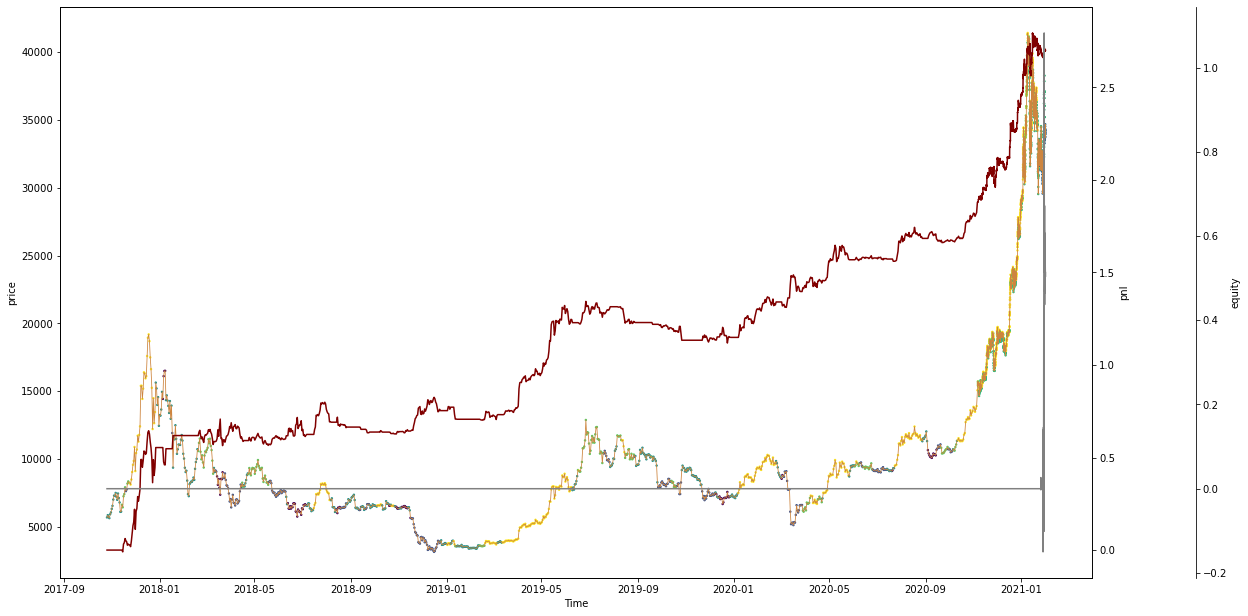

In [9]:
def plot_result(data):
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18.5, 10.5, forward=True)

    ax1.set_xlabel('Time')
    ax1.set_ylabel('price')
    ax1.plot(data['Time'], data['price'],color='peru',linewidth=0.8)
    ax1.scatter(data['Time'],data['price'],c=data['position_x'],s=2)
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('position')
    ax2.set_ylabel('pnl')
    ax2.plot(data['Time'],data['pnl'].cumsum(),color='maroon') 
    
    ax3= ax1.twinx()
    ax3.spines["right"].set_position(("axes", 1.1))
    ax3.set_ylabel('equity')
    ax3.plot(data['Time'],data['equity'],color='grey')
#     ax3.plot(data['Time'],data['Fee'])

    number_trades=sum(data['position_x'].diff()!=0)
    print("Est Fee:" + str(number_trades*0.002))
    print("Total Return:"+ str(round(data['pnl'].sum(),2)))
    print("Sharp Ratio:"+ str(round(data['pnl'].sum()/data['pnl'].cumsum().std(),2)))

x=get_performance(portfolio)
plot_result(x.tail(6000))

In [8]:
x.tail(20)

,Time,position_x,pnl,price,position_y,Fee,liability,asset,equity
3152,2021-01-30 19:00:00.000000000,-0.333333,-0.000398,34295.00,0.000225,1.787172,-7.110015,7.716997,0.606981
3153,2021-01-30 20:00:00.000000000,-0.333333,0.006148,33662.48,0.000225,1.787172,-7.110015,7.574668,0.464653
3154,2021-01-30 21:00:00.000000000,-0.333333,-0.000867,33750.01,0.000225,1.787172,-7.110015,7.594364,0.484349
3309,2021-01-30 21:38:05.417000055,-0.333333,0.000000,33750.01,0.000035,1.812899,-0.678510,1.181862,0.503353
3155,2021-01-30 22:00:00.000000000,-0.333333,-0.004790,34234.97,0.000035,1.812899,-0.678510,1.198845,0.520335
3156,2021-01-30 23:00:00.000000000,-0.333333,-0.000020,34237.00,0.000035,1.812899,-0.678510,1.198916,0.520406
3157,2021-01-31 00:00:00.000000000,-1.000000,0.000256,34210.70,0.000035,1.812899,-0.678510,1.197995,0.519485
3158,2021-01-31 01:00:00.000000000,-0.333333,0.002525,33951.57,0.000035,1.812899,-0.678510,1.188921,0.510411
3159,2021-01-31 02:00:00.000000000,-0.333333,0.002934,34250.42,0.000035,1.812899,-0.678510,1.199386,0.520876
3160,2021-01-31 03:00:00.000000000,-0.333333,0.000953,34348.35,0.000035,1.812899,-0.678510,1.202815,0.524305
